При подготовке использовались [материалы](https://github.com/mannefedov/compling_nlp_hse_course/blob/master/2020/nn_intro_torch.ipynb) курса Михаила Нефедова

In [1]:
!pip install ipdb

     |████████████████████████████████| 790 kB 6.1 MB/s 
     |████████████████████████████████| 374 kB 26.1 MB/s 
  Created wheel for ipdb: filename=ipdb-0.13.9-py3-none-any.whl size=11648 sha256=4a2e069532c9940533030c8ebd45b6075c835089292a17fb8d1c931b31d571a0
  Stored in directory: /root/.cache/pip/wheels/65/cd/cc/aaf92acae337a28fdd2aa4d632196a59745c8c39f76eaeed01
Successfully built ipdb
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 

In [2]:
import pandas as pd
import numpy as np
from string import punctuation
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
import ipdb

### Классификация твиттов по тональности



#### Скачивание и подготовка данных

In [3]:
!wget -O positive.csv https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv?dl=0
!wget -O negative.csv https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv?dl=0

--2021-11-22 17:07:19--  https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/fnpq3z4bcnoktiv/positive.csv [following]
--2021-11-22 17:07:19--  https://www.dropbox.com/s/raw/fnpq3z4bcnoktiv/positive.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0aa2627f9d565fed7467d074d6.dl.dropboxusercontent.com/cd/0/inline/BaeJP4sPVI-yhq51YjCAiepn6INqFUesEfIJT-brZrF-hTKDmR78KrO3QIELr7hHtwebDOVZN725A2sw4gkocS99cSzzzNbRfNBpq8Db6Z6NCJFlQGrfo6MVuTHF-8904V-wWJqv4u0kHzRIEX033Rre/file# [following]
--2021-11-22 17:07:19--  https://uc0aa2627f9d565fed7467d074d6.dl.dropboxusercontent.com/cd/0/inline/BaeJP4sPVI-yhq51YjCAiepn6INqFUesEfIJT-brZrF-hTKDmR78KrO3QIELr7hHtwebDOVZN725A2sw4gkoc

In [4]:
pos_tweets = pd.read_csv('positive.csv', encoding='utf-8', sep=';', header=None,  names=[0,1,2,'text','tone',5,6,7,8,9,10,11])

In [5]:
neg_tweets = pd.read_csv('negative.csv', encoding='utf-8', sep=';', header=None, names=[0,1,2,'text','tone',5,6,7,8,9,10,11] )
neg_tweets['tone'] = 0

In [6]:
all_tweets_data = pos_tweets.append(neg_tweets)
print(len(all_tweets_data))

226834


In [7]:
tweets_data = shuffle(all_tweets_data[['text','tone']])[:100000]

In [8]:
train_sentences, val_sentences = train_test_split(tweets_data, test_size=0.1)

In [9]:
train_sentences[:10]

,text,tone
94228,"раз у меня есть, значит всем уже дали :D http:...",1
37349,RT @voqifumykag: Котэ внезапно начало оставлят...,1
75264,"Интересная реакция мужа- рот открыт,глаза выпу...",1
1585,RT @hrus_tyash: бедного парнишу замуучили(,0
36136,"RT @ytaxohaxe: я опять еду в тамбов, блин :(",0
98373,@Batsugar1 би фб скрийншотд өртчихлөө боллоо....,0
23520,RT @Creative_Link: Дождались! Официальный трей...,1
89674,@Senkovich_ не я боюсь лесников)))они страшные...,1
1874,"@aluanten тоже самое, только температура побол...",0
43216,http://t.co/kABeb5xjPZ Если взять кусок бумаги...,1


In [10]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

Теперь нам нужно собрать все уникальные слова в словарь. Лучше сразу посчитать количество упоминаний, чтобы отсеять самые редкие.

In [11]:
vocab = Counter()

for text in tweets_data['text']:
    vocab.update(preprocess(text))
print('всего уникальных токенов:', len(vocab))

всего уникальных токенов: 202260


In [12]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 2:
        filtered_vocab.add(word)
print('уникальных токенов, втретившихся больше 2 раз:', len(filtered_vocab))

уникальных токенов, втретившихся больше 2 раз: 32447


In [13]:
#создаем словарь с индексами word2id, для спецсимвола паддинга дефолтный индекс - 0
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [14]:
#обратный словарь для того, чтобы раскодировать последовательность
id2word = {i:word for word, i in word2id.items()}

In [15]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE


device(type='cuda')

#### паддинги

In [16]:
MAX_LEN = 0

for text in tweets_data.text:
    tokens = preprocess(text)
    MAX_LEN = max(len(tokens), MAX_LEN)
MAX_LEN

40

##### F.pad 
паддим каждую последовательность до желаемой длины

In [17]:

X = torch.LongTensor(size=(train_sentences.shape[0], MAX_LEN))

for i, text in enumerate(train_sentences.text):
    tokens = preprocess(text) # токенизируем
    
    ids = [word2id[token] for token in tokens if token in word2id][:MAX_LEN]

    ids = F.pad(torch.LongTensor(ids), (0,MAX_LEN-len(ids)))
    X[i] = ids

In [18]:
print(X[4].shape)
print(X[4])
print([id2word[int(id_)] for id_ in  X[4]])

torch.Size([40])
tensor([20550, 30646,  1260,  8255, 18768, 24914, 28587,     1,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
['rt', 'я', 'опять', 'еду', 'в', 'тамбов', 'блин', '', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']


##### torch.nn.utils.rnn.pad_sequence
альтернатива - добиваем паддингами до самого длинного предложения из переданных

In [19]:
X = []

for text in train_sentences.text:
    tokens = preprocess(text) 
    ids = torch.LongTensor([word2id[token] for token in tokens if token in word2id]) 
    X.append(ids)

In [20]:
X = pad_sequence(X, batch_first=True) 
X.shape

torch.Size([90000, 39])

In [21]:
X = X[:, :5] # если хочется обрезать короче

In [22]:
X.shape

torch.Size([90000, 5])

#### Dataset & DataLoader

In [44]:
class TweetsDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['text'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = dataset['tone'].values
        self.device = DEVICE

    def __len__(self): #это обязательный метод, он должен уметь считать длину датасета
        return self.length

    def __getitem__(self, index): #еще один обязательный метод. По индексу возвращает элемент выборки
        tokens = self.preprocess(self.dataset[index]) # токенизируем
        ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        y = [self.target[index]]
        return ids, y
    
    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
      ids, y = list(zip(*batch))
      padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
      #мы хотим применять BCELoss, он будет брать на вход predicted размера batch_size x 1 (так как для каждого семпла модель будет отдавать одно число), target размера batch_size x 1
      y = torch.Tensor(y).to(self.device) # tuple ([1], [0], [1])  -> Tensor [[1.], [0.], [1.]] 
      return padded_ids, y

##### создаем итераторы по данным для трейна и теста

In [50]:
train_dataset = TweetsDataset(train_sentences, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [51]:
len(train_iterator)

88

In [52]:
batch = next(iter(train_iterator))

In [53]:
batch

(tensor([[ 2531, 19148, 23453,  ...,     0,     0,     0],
         [20550, 14169,  5054,  ...,     0,     0,     0],
         [ 3571,  4693,  3343,  ...,     0,     0,     0],
         ...,
         [  839, 10022,  5183,  ...,     0,     0,     0],
         [25139, 11284, 26991,  ...,     0,     0,     0],
         [20550, 16833, 18768,  ...,     0,     0,     0]], device='cuda:0'),
 tensor([[0.],
         [1.],
         [1.],
         ...,
         [0.],
         [0.],
         [1.]], device='cuda:0'))

In [54]:
val_dataset = TweetsDataset(val_sentences, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [55]:
test_batch = next(iter(val_iterator))

#### Embedding  слой
перед тем как собрать сеть целиком посмотрим на слои, которые пока не обсуждались


In [56]:

layer = nn.Embedding(10, 5) # первый параметр  - размер всего словаря, второй параметр размер получаемого эмбеддинга

In [57]:
layer.weight

Parameter containing:
tensor([[-0.1129,  1.0160, -0.4580,  0.5245, -1.4977],
        [-0.4549,  0.2672, -1.6197,  0.5033,  0.8799],
        [-0.0406, -1.0851, -0.4708,  0.8817, -0.2708],
        [ 1.0036,  0.0828,  2.3485, -0.8574, -0.5525],
        [ 1.6242,  1.0012,  1.0595, -1.1719, -0.4508],
        [ 1.7854,  1.0629, -0.5048, -1.9477, -0.0156],
        [ 1.4465,  0.3000, -1.6910,  0.7483, -1.9134],
        [ 1.3914,  0.5289, -1.8733, -0.2444,  0.3824],
        [ 0.6322,  1.7238,  1.4260,  2.0190,  0.6332],
        [-0.5506,  0.8102,  0.7116,  0.1787, -0.2447]], requires_grad=True)

In [58]:
input = torch.tensor([1, 4, 3, 3, 7, 0, 9])
result = layer(input)
result

tensor([[-0.4549,  0.2672, -1.6197,  0.5033,  0.8799],
        [ 1.6242,  1.0012,  1.0595, -1.1719, -0.4508],
        [ 1.0036,  0.0828,  2.3485, -0.8574, -0.5525],
        [ 1.0036,  0.0828,  2.3485, -0.8574, -0.5525],
        [ 1.3914,  0.5289, -1.8733, -0.2444,  0.3824],
        [-0.1129,  1.0160, -0.4580,  0.5245, -1.4977],
        [-0.5506,  0.8102,  0.7116,  0.1787, -0.2447]],
       grad_fn=<EmbeddingBackward0>)

#### Dropout

In [59]:

dropout = nn.Dropout(p=0.5)

In [60]:
result

tensor([[-0.4549,  0.2672, -1.6197,  0.5033,  0.8799],
        [ 1.6242,  1.0012,  1.0595, -1.1719, -0.4508],
        [ 1.0036,  0.0828,  2.3485, -0.8574, -0.5525],
        [ 1.0036,  0.0828,  2.3485, -0.8574, -0.5525],
        [ 1.3914,  0.5289, -1.8733, -0.2444,  0.3824],
        [-0.1129,  1.0160, -0.4580,  0.5245, -1.4977],
        [-0.5506,  0.8102,  0.7116,  0.1787, -0.2447]],
       grad_fn=<EmbeddingBackward0>)

In [61]:
dropout(result)

tensor([[-0.0000,  0.0000, -0.0000,  1.0066,  1.7598],
        [ 3.2485,  2.0024,  0.0000, -2.3439, -0.9016],
        [ 0.0000,  0.0000,  0.0000, -1.7149, -0.0000],
        [ 0.0000,  0.0000,  0.0000, -1.7149, -0.0000],
        [ 2.7828,  1.0578, -0.0000, -0.0000,  0.0000],
        [-0.0000,  0.0000, -0.0000,  1.0491, -2.9955],
        [-0.0000,  0.0000,  0.0000,  0.3575, -0.0000]], grad_fn=<MulBackward0>)

#### MLP model

In [62]:
class MLP(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        
        super().__init__()          
        # указываем в атрибутах класса, какие слои и активации нам понадобятся
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.emb2h = nn.Linear(embedding_dim, 10) 
        self.act1 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.h2out = nn.Linear(10, 1)
        self.act2 = nn.Sigmoid()
        
        
    def forward(self, text): #необходимый метод,  в нем указываем, как именно связываются слои/активации между собой
        # batch_size x seq_len
        #ipdb.set_trace()
        embedded = self.embedding(text)   # переводим последовательность индексов в последовательность эмбеддингов
        # batch_size x seq_len x embedding_dim
        
        mean_emb = torch.mean(embedded, dim=1) # считаем средний эмбеддинг предложения
        # batch_size x embedding_dim
        hidden = self.emb2h(mean_emb) # пропускаем эмбеддинг через полносвязный слой 
        # batch_size x 10
        hidden = self.act1(hidden)
        # batch_size x 10
        hidden = self.dropout(hidden)
        # batch_size x 10
        out = self.h2out(hidden) # возвращаем одно число для каждого семпла
        # batch_size x 1
        proba = self.act2(out) # пропускаем число через сигмоиду, делая из него вероятность класса
        # batch_size x 1
        return proba

In [66]:
batch, y = next(iter(train_iterator))
batch, y = batch.to(device='cpu'), y.to(device='cpu')
print(batch.shape)
print(y.shape)

torch.Size([1024, 26])
torch.Size([1024, 1])


In [67]:
y

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])

In [69]:
#пропустим через модель наш первый батч, чтобы проверить, что все работает
model = MLP(len(id2word), 5)
output = model(batch)
output

tensor([[0.5625],
        [0.5802],
        [0.5628],
        ...,
        [0.6047],
        [0.5547],
        [0.5955]], grad_fn=<SigmoidBackward0>)

In [70]:
loss = nn.BCELoss()
loss(output, y)

tensor(0.6968, grad_fn=<BinaryCrossEntropyBackward0>)

In [71]:
model.state_dict() # где посмотреть веса модели (ее параметры)

OrderedDict([('embedding.weight',
              tensor([[-0.7264,  0.9117, -0.2796,  0.1459,  0.8772],
                      [ 2.3701, -0.9390, -0.6720,  0.3873,  0.6177],
                      [-1.3078, -0.3298, -1.2601,  0.7373, -0.9859],
                      ...,
                      [-2.4051, -1.1373,  1.2155,  1.8522,  0.4348],
                      [-0.1921,  1.5044, -0.6219, -0.1743, -0.0444],
                      [-0.1205, -1.8843,  1.4323,  0.7829,  0.1420]])),
             ('emb2h.weight',
              tensor([[ 0.0139,  0.4043,  0.3107, -0.0921,  0.2627],
                      [ 0.1829, -0.4391, -0.2499,  0.4222,  0.1184],
                      [ 0.1376, -0.0174, -0.2952, -0.1242,  0.1912],
                      [-0.3744,  0.0301,  0.4157,  0.3060,  0.1470],
                      [ 0.2710,  0.2957, -0.0750, -0.4330,  0.0622],
                      [ 0.3150, -0.4102, -0.2920,  0.1753, -0.4352],
                      [ 0.3288,  0.3142,  0.2128,  0.0723, -0.3610],
         

#### training loop, логика обучения и валидации

теперь нам нужны функции для обучения и валидации,
каждый вызов функции - одна эпоха обучения 

За одну эпоху нам надо для каждого батча:

-- применить к нему модель, 

-- посчитать значение функции потерь, 

-- посчитать градиенты,

-- обновить веса (параметры модели)


In [74]:
def train(model, iterator, optimizer, criterion):
    print('Training...')
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах
    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (texts, ys) in enumerate(iterator): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        #ipdb.set_trace()
        preds_proba = model(texts) #прогоняем данные через модель
        loss = criterion(preds_proba, ys) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        
        if not (i + 1) % 20:
            print(f'Train loss: {epoch_loss/i}')
        
    return epoch_loss / len(iterator) # возвращаем среднее значение функции потерь по всей выборке

In [78]:
def evaluate(model, iterator, criterion):
    print("\nValidating...")
    epoch_loss = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            predictions = model(texts)  # делаем предсказания на тесте
            loss = criterion(predictions, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item() 
            if not (i + 1) % 5:
              print(f'Val loss: {epoch_loss/i}')
        
    return epoch_loss / len(iterator) # возвращаем средний лосс по батчам

#### инициализируем модель, задаем оптимизатор и функцию потерь

In [79]:
model = MLP(len(word2id), 5)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss() # Binary Cross Entropy

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

#### запуск обучения!

In [81]:
losses = []
losses_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)

    epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)


starting Epoch 0
Training...
Train loss: 0.7189970016479492
Train loss: 0.6993474929760664
Train loss: 0.6925876888178163
Train loss: 0.6887279718737059

Validating...
Val loss: 0.842970460653305
Val loss: 0.7489206790924072

starting Epoch 1
Training...
Train loss: 0.7089811469379225
Train loss: 0.6892984799849682
Train loss: 0.6820291341361353
Train loss: 0.6776881255681002

Validating...
Val loss: 0.8257678598165512
Val loss: 0.7343371709187826

starting Epoch 2
Training...
Train loss: 0.6937072716261211
Train loss: 0.6732233533492455
Train loss: 0.6662579148502673
Train loss: 0.6629102033904836

Validating...
Val loss: 0.8103078901767731
Val loss: 0.719977491431766

starting Epoch 3
Training...
Train loss: 0.6797529427628768
Train loss: 0.6607765203867203
Train loss: 0.6534266855757115
Train loss: 0.6491740896731992

Validating...
Val loss: 0.7929738163948059
Val loss: 0.7053716580073038

starting Epoch 4
Training...
Train loss: 0.664960619650389
Train loss: 0.6465478356067951
Tra

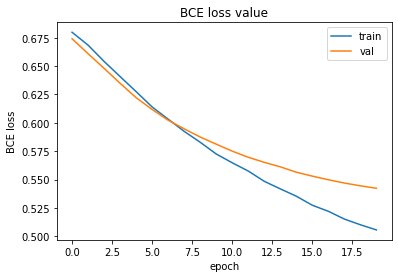

In [82]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# как инициализировать модель готовыми эмбеддингами

In [83]:
import gensim

In [84]:
texts = all_tweets_data.text.apply(preprocess).tolist()

In [85]:
len(texts)

226834

In [86]:
%%time
w2v = gensim.models.Word2Vec(texts, size=100, window=5, min_count=1)

CPU times: user 2min 28s, sys: 3.47 s, total: 2min 32s
Wall time: 2min 5s


In [87]:
w2v.wv.most_similar('веселый')


[('шикарный', 0.9679120779037476),
 ('замечательный', 0.9620940685272217),
 ('офигенный', 0.9620062112808228),
 ('приятный', 0.9600216150283813),
 ('прекрасный', 0.9540168046951294),
 ('ахуенный', 0.9530630111694336),
 ('интересный', 0.9490739703178406),
 ('сильный', 0.948347270488739),
 ('летний', 0.9479907751083374),
 ('легкий', 0.945224404335022)]

In [88]:
weights = np.zeros((len(word2id), 100))
count = 0
for word, i in word2id.items():
    if word == 'PAD':
        continue   
    try:
        weights[i] = w2v.wv[word]    
    except KeyError:
      count += 1
      # oov словам сопоставляем случайный вектор
      weights[i] = np.random.normal(0,0.1,100)

In [89]:
class MLP_w2v(nn.Module):
    
    def __init__(self, vocab_size):
        
        super().__init__()          
        # указываем в атрибутах класса, какие слои и активации нам понадобятся
        self.embedding = nn.Embedding(vocab_size, 100)
        self.embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.emb2h = nn.Linear(100, 10) 
        self.act1 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.h2out = nn.Linear(10, 1)
        self.act2 = nn.Sigmoid() 
        
        
    def forward(self, text): #необходимый метод,  в нем указываем, как именно связываются слои/активации между собой
        
        embedded = self.embedding(text)   # переводим последовательность индексов в последовательность эмбеддингов
        mean_emb = torch.mean(embedded, dim=1) # считаем средний эмбеддинг предложения
        hidden = self.emb2h(mean_emb) # пропускаем эмбеддинг через полносвязный слой 
        hidden = self.dropout(hidden)
        hidden = self.act1(hidden)
        hidden = self.dropout(hidden)
        out = self.h2out(hidden) # возвращаем одно число для каждого семла
        proba = self.act2(out) # пропускаем число через сигмоиду, делая из него вероятность класса
        
        return proba

In [98]:
model = MLP_w2v(len(word2id))
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss() # Binary Cross Entropy

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [99]:
losses = []
losses_eval = []

for i in range(12):
    print(f'\nstarting Epoch {i}')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)

    epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)


starting Epoch 0
Training...
Train loss: 0.7309499853535703
Train loss: 0.7118812646621313
Train loss: 0.7055377101494094
Train loss: 0.7021082096462008

Validating...
Val loss: 0.863175630569458
Val loss: 0.7671780387560526

starting Epoch 1
Training...
Train loss: 0.727609163836429
Train loss: 0.7078027786352695
Train loss: 0.7011885067163888
Train loss: 0.6972869453550894

Validating...
Val loss: 0.854070395231247
Val loss: 0.7582507332166036

starting Epoch 2
Training...
Train loss: 0.7182435958009017
Train loss: 0.6986031486437871
Train loss: 0.6911022875268581
Train loss: 0.686661772335632

Validating...
Val loss: 0.8345714509487152
Val loss: 0.7412925561269125

starting Epoch 3
Training...
Train loss: 0.7009571414244803
Train loss: 0.6813713480264713
Train loss: 0.6739861217595763
Train loss: 0.6685849382907529

Validating...
Val loss: 0.8048515170812607
Val loss: 0.715713103612264

starting Epoch 4
Training...
Train loss: 0.6797273504106622
Train loss: 0.6604803296235892
Train

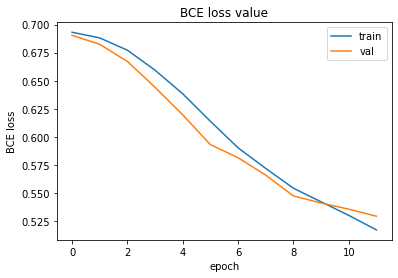

In [100]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()